# Importing dependencies

In [1]:
from time import process_time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Data Pre-Processing

In [2]:
db = pd.read_csv('./KaggleV2-May-2016.csv')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [3]:
db.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
#convert scheduled and appointment day to datetime format
db['ScheduledDay'] = pd.to_datetime(db['ScheduledDay']).dt.date.astype('datetime64[ns]')
db['AppointmentDay'] = pd.to_datetime(db['AppointmentDay']).dt.date.astype('datetime64[ns]')

#rename incorrect column names
db = db.rename(columns={'Hipertension' : 'Hypertension', 'Handcap' : 'Handicap','SMS_received' : 'SMSReceived', 'No-show' : 'NoShow'})

# #remove patientID and appointmentID
db.drop(['PatientId','AppointmentID'], axis = 1, inplace = True)

In [5]:
db.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
#print unique values
print("Unique Values in `Gender` => {}".format(db.Gender.unique()))
print("Unique Values in `Scholarship` => {}".format(db.Scholarship.unique()))
print("Unique Values in `Hypertension` => {}".format(db.Hypertension.unique()))
print("Unique Values in `Diabetes` => {}".format(db.Diabetes.unique()))
print("Unique Values in `Alcoholism` => {}".format(db.Alcoholism.unique()))
print("Unique Values in `Handicap` => {}".format(db.Handicap.unique()))
print("Unique Values in `SMSReceived` => {}".format(db.SMSReceived.unique()))
print("Unique Values in `NoShow` => {}".format(db.NoShow.unique()))

Unique Values in `Gender` => ['F' 'M']
Unique Values in `Scholarship` => [0 1]
Unique Values in `Hypertension` => [1 0]
Unique Values in `Diabetes` => [0 1]
Unique Values in `Alcoholism` => [0 1]
Unique Values in `Handicap` => [0 1 2 3 4]
Unique Values in `SMSReceived` => [0 1]
Unique Values in `NoShow` => ['No' 'Yes']


In [7]:
#cap values in handicap to 0 & 1
db.Handicap = db.Handicap.map(lambda x: int(x>=1))
print("Unique Values in `Handicap` => {}".format(db.Handicap.unique()))

#convert noshow into 0&1
db.NoShow = db.NoShow.map(lambda x : int(x == 'Yes'))
print("Unique Values in `NoShow` => {}".format(db.NoShow.unique()))

Unique Values in `Handicap` => [0 1]
Unique Values in `NoShow` => [0 1]


In [8]:
#check for negative ages
db[db.Age < 0]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
99832,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,0


In [9]:
#remove the single record
db = db[db.Age >= 0]
db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110526 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Gender          110526 non-null  object        
 1   ScheduledDay    110526 non-null  datetime64[ns]
 2   AppointmentDay  110526 non-null  datetime64[ns]
 3   Age             110526 non-null  int64         
 4   Neighbourhood   110526 non-null  object        
 5   Scholarship     110526 non-null  int64         
 6   Hypertension    110526 non-null  int64         
 7   Diabetes        110526 non-null  int64         
 8   Alcoholism      110526 non-null  int64         
 9   Handicap        110526 non-null  int64         
 10  SMSReceived     110526 non-null  int64         
 11  NoShow          110526 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(2)
memory usage: 11.0+ MB


In [10]:
#create new columns indicating the waiting days and appointed dayofweek and drop the day columns
db['WaitingDays'] = (db['AppointmentDay'] - db['ScheduledDay']).dt.days
db['AppointmentDOW'] = db['AppointmentDay'].map(lambda x: x.weekday())
db.drop(['ScheduledDay', 'AppointmentDay'], axis = 1, inplace = True)
db.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,WaitingDays,AppointmentDOW
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,4
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,4
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,4
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,4
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,4


In [11]:
#check for negative waiting days
db[db.WaitingDays < 0]

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,WaitingDays,AppointmentDOW
27033,M,38,RESISTÊNCIA,0,0,0,0,1,0,1,-1,0
55226,F,19,SANTO ANTÔNIO,0,0,0,0,1,0,1,-1,1
64175,F,22,CONSOLAÇÃO,0,0,0,0,0,0,1,-1,2
71533,F,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,-6,3
72362,M,7,TABUAZEIRO,0,0,0,0,0,0,1,-1,1


In [12]:
#drop these records
db = db[db.WaitingDays >= 0]
db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Gender          110521 non-null  object
 1   Age             110521 non-null  int64 
 2   Neighbourhood   110521 non-null  object
 3   Scholarship     110521 non-null  int64 
 4   Hypertension    110521 non-null  int64 
 5   Diabetes        110521 non-null  int64 
 6   Alcoholism      110521 non-null  int64 
 7   Handicap        110521 non-null  int64 
 8   SMSReceived     110521 non-null  int64 
 9   NoShow          110521 non-null  int64 
 10  WaitingDays     110521 non-null  int64 
 11  AppointmentDOW  110521 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.0+ MB


In [13]:
#compare no. of show and noshows as %
db.groupby('NoShow').size()*100/db.groupby('NoShow').size().sum()

NoShow
0    79.810172
1    20.189828
dtype: float64

In [14]:
#encode non-integer labels
encoder = LabelEncoder()
db['Gender'] = encoder.fit_transform(db['Gender'])
db['Neighbourhood'] = encoder.fit_transform(db['Neighbourhood'])
db.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,WaitingDays,AppointmentDOW
0,0,62,39,0,1,0,0,0,0,0,0,4
1,1,56,39,0,0,0,0,0,0,0,0,4
2,0,62,45,0,0,0,0,0,0,0,0,4
3,0,8,54,0,0,0,0,0,0,0,0,4
4,0,56,39,0,1,1,0,0,0,0,0,4


In [15]:
#split into target and features
X = db.drop(['NoShow'],axis = 1)
y = db.NoShow

In [16]:
#further split into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

#convert to np arrays
X_train = np.array(X_train).reshape(-1,11).astype(float)
X_test = np.array(X_test).reshape(-1,11).astype(float)
y_train = np.array(y_train)
y_test = np.array(y_test)

#scale numerical features
X_train[:,1] = (X_train[:,1] - np.mean(X_train[:,1]))/np.std(X_train[:,1])
X_train[:,2] = (X_train[:,2] - np.mean(X_train[:,2]))/np.std(X_train[:,2])
X_train[:,9] = (X_train[:,9] - np.mean(X_train[:,9]))/np.std(X_train[:,9])
X_train[:,10] = (X_train[:,10] - np.mean(X_train[:,10]))/np.std(X_train[:,10])
X_test[:,1] = (X_test[:,1] - np.mean(X_test[:,1]))/np.std(X_test[:,1])
X_test[:,2] = (X_test[:,2] - np.mean(X_test[:,2]))/np.std(X_test[:,2])
X_test[:,9] = (X_test[:,9] - np.mean(X_test[:,9]))/np.std(X_test[:,9])
X_test[:,10] = (X_test[:,10] - np.mean(X_test[:,10]))/np.std(X_test[:,10])

# Implementation

**Part-1: Neural Network From Scratch**

In [17]:
class HiddenLayer:
    def __init__(self, n_inputs, n_neurons):
        std = np.sqrt(2/n_inputs)
        self.weights = np.random.normal(scale = std, size = (n_inputs, n_neurons))
        self.biases = np.full((1,n_neurons),0.1)
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Sigmoid:
    def forward(self, inputs):
        prob_one = 1/(1+np.exp(-inputs))
        prob_zero = 1 - prob_one
        self.output = np.c_[prob_zero, prob_one]

class ClassBalancedCE:
    def calculate(self, y_pred, y_true):
        samples = len(y_pred)
        weights = samples/np.bincount(y_true)
        weights = np.tile(weights, (samples, 1))
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        c_confidence = y_pred_clipped[range(samples), y_true]
        c_weights = weights[range(samples), y_true]
        data_loss = -c_weights*np.log(c_confidence)
        loss = np.mean(data_loss)
        return loss

class Sigmoid_ClassBalancedCE:
    def __init__(self):
        self.activation = Sigmoid()
        self.loss = ClassBalancedCE()
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        weights = samples/np.bincount(y_true)
        weight_0 = weights[0]
        weight_1 = weights[1]
        p = dvalues[:,1].copy()
        self.dinputs = weight_0*p*(1-y_true) - weight_1*(1-p)*y_true
        self.dinputs = self.dinputs/samples
        self.dinputs = self.dinputs.reshape(-1,1)

class Adam:
    def __init__(self, lr = 0.001, decay = 0., eps = 1e-7, b1 = 0.9, b2 = 0.999):
        self.lr = lr
        self.c_lr = lr
        self.decay = decay
        self.eps = eps
        self.b1 = b1
        self.b2 = b2
        self.iterations = 0
    def pre_update_params(self):
        if self.decay:
            self.c_lr = self.lr/(1+self.decay*self.iterations)
    def update_params(self, layer):
        if not hasattr(layer, 'weight_mtm'):
            layer.weight_mtm = np.zeros_like(layer.weights)
            layer.weight_chc = np.zeros_like(layer.weights)
            layer.bias_mtm = np.zeros_like(layer.biases)
            layer.bias_chc = np.zeros_like(layer.biases)
            
        layer.weight_mtm = self.b1*layer.weight_mtm + (1 - self.b1)*layer.dweights
        layer.weight_chc = self.b2*layer.weight_chc + (1 - self.b2)*(layer.dweights**2)
        layer.bias_mtm = self.b1*layer.bias_mtm + (1 - self.b1)*layer.dbiases
        layer.bias_chc = self.b2*layer.bias_chc + (1 - self.b2)*(layer.dbiases**2)

        weight_mtm_crc = layer.weight_mtm/(1 - self.b1**(1 + self.iterations))
        weight_chc_crc = layer.weight_chc/(1 - self.b2**(1 + self.iterations))
        bias_mtm_crc = layer.bias_mtm/(1 - self.b1**(1 + self.iterations))
        bias_chc_crc = layer.bias_chc/(1 - self.b2**(1 + self.iterations))

        layer.weights -= self.c_lr*weight_mtm_crc/(np.sqrt(weight_chc_crc) + self.eps)
        layer.biases -= self.c_lr*bias_mtm_crc/(np.sqrt(bias_chc_crc) + self.eps)
        
    def post_update_params(self):
        self.iterations += 1

In [18]:
#initialize and train model
layer1 = HiddenLayer(11, 8)
activation1 = ReLU()
layer2 = HiddenLayer(8,4)
activation2 = ReLU()
layer3 = HiddenLayer(4,1)
loss_activation = Sigmoid_ClassBalancedCE()
optimizer = Adam(lr = 0.003)

start_p1 = process_time()

for i in range(1500):
    #forward prop
    layer1.forward(X_train)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    loss_activation.forward(layer3.output, y_train)
    
    #backward prop
    loss_activation.backward(loss_activation.output, y_train)
    layer3.backward(loss_activation.dinputs)
    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    #param update
    optimizer.pre_update_params()
    optimizer.update_params(layer3)
    optimizer.update_params(layer2)
    optimizer.update_params(layer1)
    optimizer.post_update_params()
    
end_p1 = process_time()
time_p1 = end_p1 - start_p1

In [19]:
#make predictions on validation set
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
layer3.forward(activation2.output)
loss_activation.forward(layer3.output, y_test)
y_pred_p1 = np.argmax(loss_activation.output, axis = 1)

In [20]:
#evaluate predictions
acc_p1 = accuracy_score(y_test, y_pred_p1)
f1_score_p1 = f1_score(y_test, y_pred_p1, average = 'weighted')
p_p1, r_p1, th = precision_recall_curve(y_test, y_pred_p1)
pr_auc_p1 = auc(r_p1, p_p1)
cm_p1 = confusion_matrix(y_test, y_pred_p1)

**Part-2: PyTorch Implementation**

In [21]:
#convert data to tensors
Xtrain_tensor = torch.from_numpy(X_train).float()
ytrain_tensor = torch.from_numpy(y_train).float().reshape([-1,1])
Xtest_tensor =  torch.from_numpy(X_test).float()
ytest_tensor =  torch.from_numpy(y_test).float().reshape([-1,1])

In [22]:
n_inputs = 11
n_hidden1 = 8
n_hidden2 = 4

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(n_inputs, n_hidden1)
        self.layer2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer3 = nn.Linear(n_hidden2, 1)
        self.relu = nn.ReLU()

        init.kaiming_normal_(self.layer1.weight, mode = 'fan_in', nonlinearity = 'relu')
        init.kaiming_normal_(self.layer2.weight, mode = 'fan_in', nonlinearity = 'relu')
        init.kaiming_normal_(self.layer3.weight, mode = 'fan_in', nonlinearity = 'relu')

        self.layer1.bias.data.fill_(0.1)
        self.layer2.bias.data.fill_(0.1)
        self.layer3.bias.data.fill_(0.1)
    def forward(self, inputs):
        out = self.layer1(inputs)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

model = NeuralNet()

weight = np.bincount(y_train)[0]/np.bincount(y_train)[1]
weight_tensor = torch.tensor(weight)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003, eps = 1e-7)

In [23]:
start_p2 = process_time()

for i in range(1500):
    #forward prop
    y_pred = model(Xtrain_tensor)
    loss = loss_fn(y_pred, ytrain_tensor)
    
    #backward prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

end_p2 = process_time()
time_p2 = end_p2 - start_p2

In [24]:
#make predictions on evalaution set
y_pred_p2 = np.empty_like(y_test)
with torch.no_grad():
    y_pred_tensor = torch.sigmoid(model(Xtest_tensor))
    y_pred_p2 = y_pred_tensor.numpy()

y_pred_p2[y_pred_p2 >= 0.5] = 1
y_pred_p2[y_pred_p2 < 0.5] = 0

In [25]:
#evaluate metrics on prediction
acc_p2 = accuracy_score(y_test, y_pred_p2)
f1_score_p2 = f1_score(y_test, y_pred_p2, average = 'weighted')
p_p2, r_p2, th = precision_recall_curve(y_test, y_pred_p2)
pr_auc_p2 = auc(r_p2, p_p2)
cm_p2 = confusion_matrix(y_test, y_pred_p2)

# Evaluation

**1. Convergence Time**

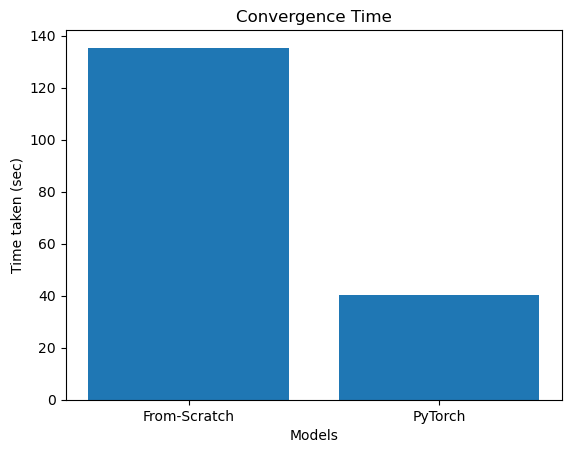

In [26]:
models = ['From-Scratch', 'PyTorch']
times = [time_p1,time_p2]
#plotting bar chart
plt.bar(models,times)
plt.title('Convergence Time')
plt.xlabel('Models')
plt.ylabel('Time taken (sec)')
plt.show()

**2. Performance Metrics**

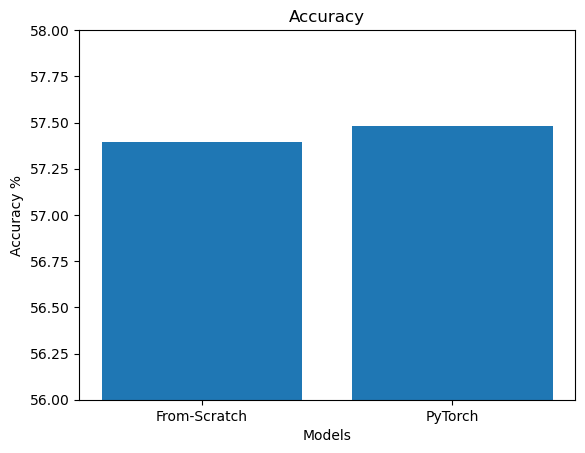

In [30]:
#accuracy
acc_tests = [acc_p1*100, acc_p2*100]

plt.bar(models, acc_tests)
plt.title('Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy %')
plt.ylim(56,58)
plt.show()

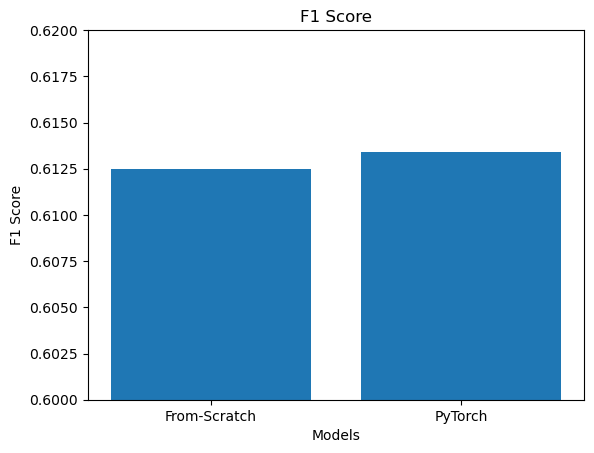

In [31]:
f1_tests = [f1_score_p1, f1_score_p2]

plt.bar(models, f1_tests)
plt.title('F1 Score')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.ylim(0.6,0.62)
plt.show()

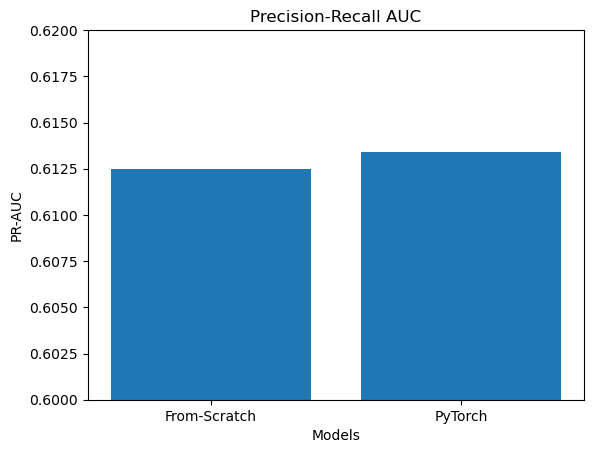

In [32]:
auc_tests = [pr_auc_p1, pr_auc_p2]

plt.bar(models, f1_tests)
plt.title('Precision-Recall AUC')
plt.xlabel('Models')
plt.ylabel('PR-AUC')
plt.ylim(0.6, 0.62)
plt.show()